<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/30_days_deep_learning_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 5-2, 特征列feature_column
特征列 通常用于对结构化数据实施特征工程时候使用，图像或者文本数据一般不会用到特征列。
### 一，特征列用法概述
使用特征列可以将类别特征转换为one-hot编码特征，将连续特征构建分桶特征，以及对多个特征生成交叉特征等等。

要创建特征列，请调用 tf.feature_column 模块的函数。该模块中常用的九个函数如下图所示，所有九个函数都会返回一个 Categorical-Column 或一个 Dense-Column 对象，但却不会返回 bucketized_column，后者继承自这两个类。

注意：所有的Catogorical Column类型最终都要通过indicator_column转换成Dense Column类型才能传入模型！

numeric_column 数值列，最常用。

bucketized_column 分桶列，由数值列生成，可以由一个数值列出多个特征，one-hot编码。

categorical_column_with_identity 分类标识列，one-hot编码，相当于分桶列每个桶为1个整数的情况。

categorical_column_with_vocabulary_list 分类词汇列，one-hot编码，由list指定词典。

categorical_column_with_vocabulary_file 分类词汇列，由文件file指定词典。

categorical_column_with_hash_bucket 哈希列，整数或词典较大时采用。

indicator_column 指标列，由Categorical Column生成，one-hot编码

embedding_column 嵌入列，由Categorical Column生成，嵌入矢量分布参数需要学习。嵌入矢量维数建议取类别数量的 4 次方根。

crossed_column 交叉列，可以由除categorical_column_with_hash_bucket的任意分类列构成。

### 二，特征列使用范例
以下是一个使用特征列解决Titanic生存问题的完整范例。


In [6]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models

def printlog(info):
  nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
  print("\n"+"========"*8 + "%s"%nowtime)
  print(info + '...\n\n')



In [2]:

!apt-get install subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 15 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd64 1.9.7-4ubuntu1 [1,183 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 subversion amd64 1.9.7-4ubuntu1 

In [3]:
!svn checkout https://github.com/lyhue1991/eat_tensorflow2_in_30_days/trunk/data/titanic

A    titanic/test.csv
A    titanic/train.csv
Checked out revision 549.


In [9]:
#================================================================================
# 一，构建数据管道
#================================================================================
printlog("step1: prepare dataset...")

dftrain_raw = pd.read_csv("/content/titanic/train.csv")
dftest_raw = pd.read_csv("/content/titanic/test.csv")

dfraw = pd.concat([dftrain_raw,dftest_raw])

def prepare_dfdata(dfraw):
  dfdata = dfraw.copy()
  dfdata.columns = [x.lower() for x in dfdata.columns]
  dfdata = dfdata.rename(columns={'survived':'label'})
  dfdata = dfdata.drop(['passengerid','name'],axis = 1)
  for col,dtype in dict(dfdata.dtypes).items():
    #判断是否包含缺失值
    if dfdata[col].hasnans:
      # 添加标识是否缺失列
      dfdata[col + '_nan'] = pd.isna(dfdata[col]).astype('int32')
      # 填充
      if dtype not in [np.object,np.str,np.unicode]:
        dfdata[col].fillna(dfdata[col].mean(),inplace=True)

      else:
        dfdata[col].fillna('',inplace = True)

  return(dfdata)

dfdata = prepare_dfdata(dfraw)
dftrain = dfdata.iloc[0:len(dftrain_raw),:]
dftest = dfdata.iloc[len(dftrain_raw):,:]

# 从 dataframe 导入数据 
def df_to_dataset(df,shuffle= True, batch_size=32):
  dfdata = df.copy()
  if 'label' not in dfdata.columns:
    ds = tf.data.Dataset.from_tensor_slices(dfdata.to_dict(orient = 'list'))
  else:
    labels = dfdata.pop('label')
    ds = tf.data.Dataset.from_tensor_slices((dfdata.to_dict(orient = 'list'),labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dfdata))
  ds = ds.batch(batch_size)

  return ds 

ds_train = df_to_dataset(dftrain)
ds_test = df_to_dataset(dftest)  


================================================================2021-01-05 09:56:18
step1: prepare dataset......




In [10]:
#================================================================================
# 二，定义特征列
#================================================================================
printlog("step2: make feature columns...")

feature_columns = []

# 数值列
for col in ['age','fare','parch','sibsp'] + [
    c for c in dfdata.columns if c.endswith('_nan')]:
    feature_columns.append(tf.feature_column.numeric_column(col))

# 分桶列
age = tf.feature_column.numeric_column('age')
age_buckets = tf.feature_column.bucketized_column(age, 
             boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# 类别列
# 注意：所有的Catogorical Column类型最终都要通过indicator_column转换成Dense Column类型才能传入模型！！
sex = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='sex',vocabulary_list=["male", "female"]))
feature_columns.append(sex)

pclass = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='pclass',vocabulary_list=[1,2,3]))
feature_columns.append(pclass)

ticket = tf.feature_column.indicator_column(
     tf.feature_column.categorical_column_with_hash_bucket('ticket',3))
feature_columns.append(ticket)

embarked = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='embarked',vocabulary_list=['S','C','B']))
feature_columns.append(embarked)

# 嵌入列
cabin = tf.feature_column.embedding_column(
    tf.feature_column.categorical_column_with_hash_bucket('cabin',32),2)
feature_columns.append(cabin)

# 交叉列
pclass_cate = tf.feature_column.categorical_column_with_vocabulary_list(
          key='pclass',vocabulary_list=[1,2,3])

crossed_feature = tf.feature_column.indicator_column(
    tf.feature_column.crossed_column([age_buckets, pclass_cate],hash_bucket_size=15))

feature_columns.append(crossed_feature)


================================================================2021-01-05 10:01:10
step2: make feature columns......




In [11]:
#================================================================================
# 三，定义模型
#================================================================================
printlog("step3: define model...")

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
  layers.DenseFeatures(feature_columns), #将特征列放入到tf.keras.layers.DenseFeatures中!!!
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


================================================================2021-01-05 10:01:13
step3: define model......




In [12]:
#================================================================================
# 四，训练模型
#================================================================================
printlog("step4: train model...")

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(ds_train,
          validation_data=ds_test,
          epochs=10)


================================================================2021-01-05 10:01:48
step4: train model......


Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
19/23 [=======================>......] - ETA: 0s - loss: 2.8203 - accuracy: 0.4871 WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'pclass': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=int32>, 'sex': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=string>, 'age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float32>, 'sibsp': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=int32>, 'parch': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=int32>, 'ticket': <tf.Tensor 'ExpandDims_11:0' shape=(None, 1) dtype=string>, 'fare': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float32>, 'cabin': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=string>, 'embarked': <tf.


================================================================2021-01-05 10:03:18
step5: eval model......


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  64        
_________________________________________________________________
dense (Dense)                multiple                  3008      
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 7,297
Trainable params: 7,297
Non-trainable params: 0
_________________________________________________________________


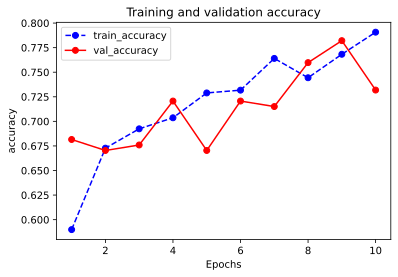

In [13]:
#================================================================================
# 五，评估模型
#================================================================================
printlog("step5: eval model...")

model.summary()


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history,"accuracy")